In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
base_path = Path('../../data/raw')
df = pd.read_csv(base_path / 'data_throwing_panda_ft.csv')

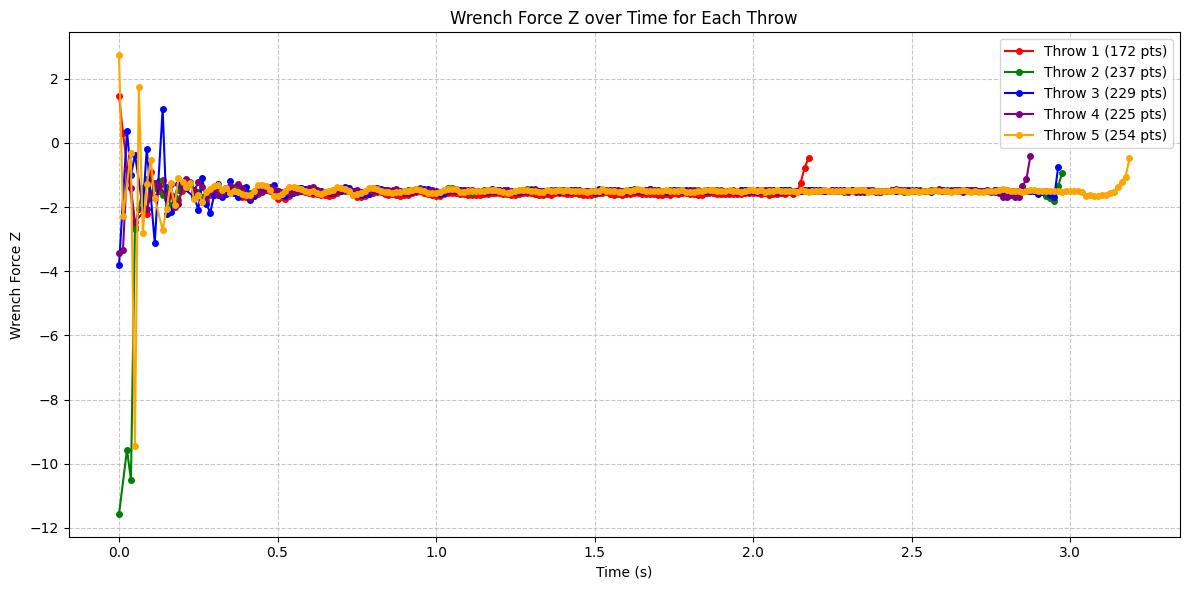

In [4]:
def identify_throws(df):
    throws = []
    current_throw = []
    current_times = []
    current_wrench = []
    start_time = None
    
    # Iterate through the rows with filtering
    for index, row in df.iterrows():
        x, y = row['ft_x'], row['ft_y']
        wrench_z = row['ft_wrench_force_z']
        timestamp = row['timestamp']
        
        # Check if point is within the specified ranges
        x_in_range = 0.0 <= x <= 0.12
        y_in_range = 0.0 <= y <= 0.14
        
        # If we hit zeros and we have points collected
        if x == 0 and y == 0:
            if current_throw and len(current_throw) >= 10:  # Only add throws with 10 or more points
                throws.append({
                    'positions': np.array(current_throw),
                    'times': np.array(current_times),
                    'wrench_z': np.array(current_wrench)
                })
            current_throw = []
            current_times = []
            current_wrench = []
            start_time = None
        # If coordinates are within range, add to current throw
        elif x_in_range and y_in_range:
            if start_time is None:
                start_time = timestamp
            current_throw.append([x, y])
            current_times.append(timestamp - start_time)  # Time relative to throw start
            current_wrench.append(wrench_z)
    
    # Add the last throw if there are points remaining and it has enough points
    if current_throw and len(current_throw) >= 10:
        throws.append({
            'positions': np.array(current_throw),
            'times': np.array(current_times),
            'wrench_z': np.array(current_wrench)
        })
    
    return throws

def plot_wrench_z(df):
    
    # Get throws
    throws = identify_throws(df)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Colors for different throws
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    
    # Plot each throw
    for i, throw in enumerate(throws):
        color = colors[i % len(colors)]
        times = throw['times']
        wrench_z = throw['wrench_z']
        
        plt.plot(times, wrench_z, 
                label=f'Throw {i+1} ({len(times)} pts)',
                color=color, marker='o', markersize=4)
    
    # Customize the plot
    plt.xlabel('Time (s)')
    plt.ylabel('Wrench Force Z')
    plt.title('Wrench Force Z over Time for Each Throw')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

plot_wrench_z(df)

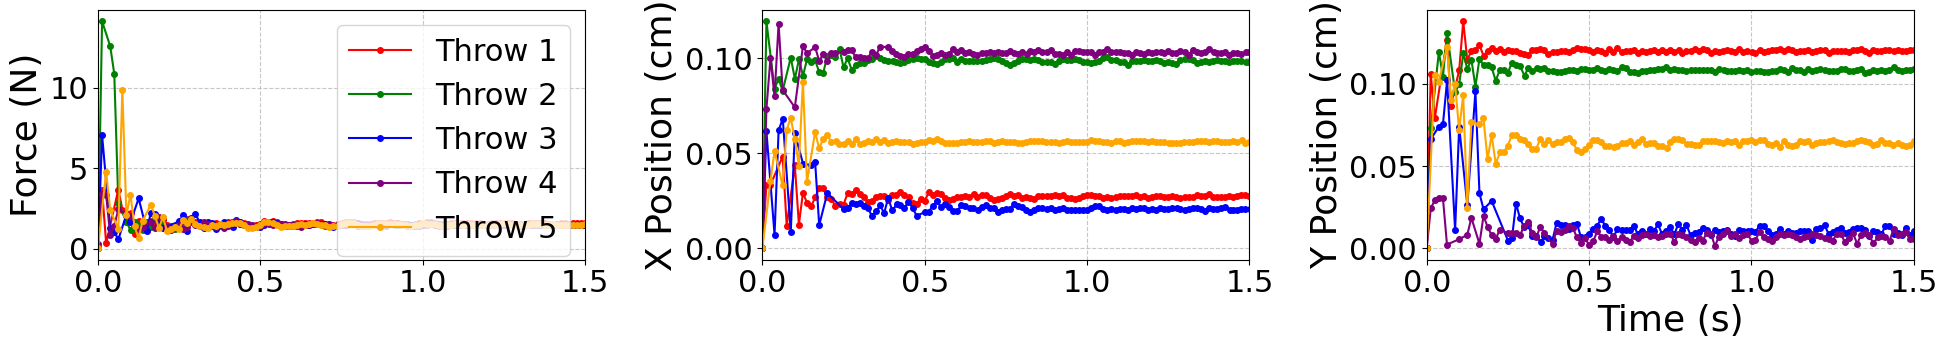

In [18]:
def identify_throws(df):
    throws = []
    current_throw = []
    current_times = []
    current_panda_x = []
    current_panda_y = []
    current_forces = []
    start_time = None
    
    # Iterate through the rows with filtering
    for index, row in df.iterrows():
        x, y = row['ft_x'], row['ft_y']
        panda_x = row['panda_x']
        panda_y = row['panda_y']
        timestamp = row['timestamp']
        
        # Calculate force magnitude
        force_magnitude = np.sqrt(row['ft_force_x']**2 + row['ft_force_y']**2 + row['ft_force_z']**2)
        
        # Check if point is within the specified ranges
        x_in_range = 0.0 <= x <= 0.12
        y_in_range = 0.0 <= y <= 0.14
        
        # Start collecting points when we see (0,0)
        if x == 0 and y == 0:
            if current_throw and len(current_throw) >= 10:
                throws.append({
                    'positions': np.array(current_throw),
                    'times': np.array(current_times),
                    'panda_x': np.array(current_panda_x),
                    'panda_y': np.array(current_panda_y),
                    'forces': np.array(current_forces)
                })
            # Reset for new throw but include the (0,0) point
            current_throw = [[x, y]]
            start_time = timestamp
            current_times = [0.0]  # Start time at 0
            current_panda_x = [panda_x]
            current_panda_y = [panda_y]
            current_forces = [force_magnitude]
        # If coordinates are within range and time is <= 2s, add to current throw
        elif (x_in_range and y_in_range) and start_time is not None:
            relative_time = timestamp - start_time
            if relative_time <= 2.0:  # Only include points up to 2 seconds
                current_throw.append([x, y])
                current_times.append(relative_time)
                current_panda_x.append(panda_x)
                current_panda_y.append(panda_y)
                current_forces.append(force_magnitude)
    
    # Add the last throw if there are points remaining and it has enough points
    if current_throw and len(current_throw) >= 10:
        throws.append({
            'positions': np.array(current_throw),
            'times': np.array(current_times),
            'panda_x': np.array(current_panda_x),
            'panda_y': np.array(current_panda_y),
            'forces': np.array(current_forces)
        })
    
    return throws

def plot_time_series(df):
    # Set the font size for all text elements
    plt.rcParams.update({'font.size': 24,
                        'axes.labelsize': 26,
                        'axes.titlesize': 26,
                        'xtick.labelsize': 22,
                        'ytick.labelsize': 22,
                        'legend.fontsize': 22})
    # Get throws
    throws = identify_throws(df)
    
    # Create three subplots
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4), sharex=True)
    
    # Colors for different throws
    colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', 'magenta', 'yellow']
    
    # Plot each throw
    for i, throw in enumerate(throws):
        color = colors[i % len(colors)]
        positions = throw['positions']
        times = throw['times']
        forces = throw['forces']
        
        # Plot force magnitude over time
        ax0.plot(times, forces,
                label=f'Throw {i+1}',
                color=color, marker='o', markersize=4)
        
        # Plot contact X position over time
        ax1.plot(times, positions[:, 0], 
                label=f'Throw {i+1}',
                color=color, marker='o', markersize=4)
        
        # Plot contact Y position over time
        ax2.plot(times, positions[:, 1],
                label=f'Throw {i+1}',
                color=color, marker='o', markersize=4)
    
    # Customize the plots
    ax0.set_ylabel('Force (N)')
    ax0.grid(True, linestyle='--', alpha=0.7)
    ax0.legend(loc='upper right')
    
    ax1.set_ylabel('X Position (cm)')
    ax1.grid(True, linestyle='--', alpha=0.7)
    #ax1.legend()
    
    ax2.set_ylabel('Y Position (cm)')
    ax2.set_xlabel('Time (s)')
    ax2.grid(True, linestyle='--', alpha=0.7)
    #ax2.legend()
    
    # Set x-axis limit to 1.5 seconds
    ax0.set_xlim(0, 1.5)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.savefig('../../img/throwing.png', dpi=600, bbox_inches='tight', format='png')
    # Show the plot
    plt.show()
plot_time_series(df)